# Fitting Regression Models

In [1]:
# Import the modules made for feature imputation/engineering/selection
import sys
sys.path.insert(0,'..')
import FeatureEngineering_Module as fe
import Imputation_Module as imp
import Encoding_Module as ec

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

## Load data and set it up for modelling

In [3]:
train_df, test_df = imp.impute_data()
train = fe.FeatureEngineering(train_df)
test = fe.FeatureEngineering(test_df)

In [4]:
# Isolating the target feature and applying log transformation for normality
saleprice = train["SalePrice"]
Y = saleprice.apply(np.log)
X = train.drop("SalePrice", axis = 1)

In [5]:
X, test = fe.Dummify(X, test)

In [6]:
print("train shape: " + str(X.shape))
print("test shape: " + str(test.shape))

train shape: (1456, 174)
test shape: (1459, 174)


## Model Evaluation

In [7]:
def model_eval(model, X = X, Y = Y):
    if str(model).split("(")[0] == "LinearRegression":
        score = np.mean(cross_val_score(estimator = ols, X = X, y = Y, cv = 5))
        pred = cross_val_predict(estimator = ols, X = X, y = Y, cv = 5)
    else:
        model.fit(X, Y)
        score = model.score(X,Y)
        pred = model.predict(X)

    RMSLE = np.sqrt(mean_squared_error(pred, Y))
    print(str(model).split("(")[0] + " model evaluation")
    print("-"*50)
    print("Mean R-square with 5 Fold Cross Validation: " + str(round(score, 5)))
    print("RMSLE: " + str(round(RMSLE, 5)))
    
    return np.exp(pred)

## Multiple Linear Regression

In [8]:
ols = LinearRegression()

In [9]:
pred = model_eval(ols)

LinearRegression model evaluation
--------------------------------------------------
Mean R-square with 5 Fold Cross Validation: 0.90038
RMSLE: 0.12482


In [10]:
import statsmodels.api as sm
features_add=sm.add_constant(X)
ols_result = sm.OLS(Y,features_add).fit().summary2()
ols_pval = ols_result.tables[1][ols_result.tables[1]['P>|t|'] < 0.05].round(4)[1:]
ols_result
# ols_pval.reindex(ols_pval["Coef."].abs().sort_values(ascending = False).index)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS              Adj. R-squared:     0.924     
Dependent Variable:  SalePrice        AIC:                -2157.7138
Date:                2020-09-24 22:19 BIC:                -1270.0945
No. Observations:    1456             Log-Likelihood:     1246.9    
Df Model:            167              F-statistic:        106.8     
Df Residuals:        1288             Prob (F-statistic): 0.00      
R-squared:           0.933            Scale:              0.011938  
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                11.0153   0.1525 72.2289 0.0000 10.7161 11.3145
MSZoning_FV           0.4457   0.0548  8.1359 0.0000  0.3382  0.5532
MSZoning_RH           0.4643   0.0540  8.5952 0.0000  0.3583  0.5702
MSZoning_RL           0.4464   0.0460  9.7016 0.0000  0.3561  0.5367
MSZoning_RM           0.4007   0.0430  9.3110 0.0000  0.3163  0.4851
LotShape_Reg          0.0059   0.0074  0.7999 0.4239 -0.0086  0.0205
LandContour_NotLvl    0.0005   0.0119  0.0433 0.9655 -0.0229  0.0239
LotConfig_CulDSac     0.0374   0.0151  2.4775 0.0134  0.0078  0.0670
LotConfig_FR         -0.0391   0.0181 -2.1594 0.0310 -0.0746 -0.0036
LotConfig_Inside     -0.0073   0.0084 -0.8650 0.3872 -0.0237  0.0092
Neighborhood_Blueste -0.0309   0.0890 -0.3472 0.7285 -0.2055  0.1437
Neighborhood_BrDale  -0.0017   0.0511 -0.0333 0.9734 -0.1019  0.0985
Neighborhood_BrkSide  0.0120   0.0426  0.2825 0.7776 -0.0715  0.0955
Neighborhood_ClearCr  0.0244   0.0422  0.5784 0.5631 -0.0584  0.1072
Neighborhood_CollgCr  0.0075   0.0341  0.2209 0.8252 -0.0593  0.0743
Neighborhood_Crawfor  0.1077   0.0392  2.7482 0.0061  0.0308  0.1845
Neighborhood_Edwards -0.0698   0.0371 -1.8845 0.0597 -0.1426  0.0029
Neighborhood_Gilbert -0.0059   0.0363 -0.1640 0.8697 -0.0771  0.0652
Neighborhood_IDOTRR  -0.0342   0.0489 -0.6993 0.4845 -0.1301  0.0617
Neighborhood_MeadowV -0.1384   0.0520 -2.6608 0.0079 -0.2405 -0.0364
Neighborhood_Mitchel -0.0253   0.0381 -0.6642 0.5067 -0.1001  0.0495
Neighborhood_NAmes   -0.0309   0.0362 -0.8552 0.3926 -0.1019  0.0400
Neighborhood_NPkVill -0.0046   0.0666 -0.0684 0.9454 -0.1352  0.1260
Neighborhood_NWAmes  -0.0302   0.0374 -0.8073 0.4197 -0.1035  0.0432
Neighborhood_NoRidge  0.0528   0.0396  1.3341 0.1824 -0.0248  0.1304
Neighborhood_NridgHt  0.0986   0.0352  2.7989 0.0052  0.0295  0.1677
Neighborhood_OldTown -0.0673   0.0437 -1.5415 0.1234 -0.1530  0.0184
Neighborhood_SWISU   -0.0481   0.0447 -1.0759 0.2822 -0.1359  0.0396
Neighborhood_Sawyer  -0.0162   0.0379 -0.4264 0.6699 -0.0905  0.0582
Neighborhood_SawyerW -0.0011   0.0367 -0.0302 0.9759 -0.0730  0.0708
Neighborhood_Somerst  0.0803   0.0420  1.9127 0.0560 -0.0021  0.1626
Neighborhood_StoneBr  0.1538   0.0390  3.9451 0.0001  0.0773  0.2302
Neighborhood_Timber   0.0094   0.0379  0.2479 0.8043 -0.0649  0.0837
Neighborhood_Veenker  0.0916   0.0484  1.8924 0.0587 -0.0034  0.1865
Condition1_Norm       0.0477   0.0094  5.0858 0.0000  0.0293  0.0661
BldgType_2fmCon       0.0257   0.0271  0.9483 0.3431 -0.0275  0.0789
BldgType_Duplex      -0.0052   0.0280 -0.1870 0.8517 -0.0603  0.0498
BldgType_Twnhs       -0.1055   0.0263 -4.0080 0.0001 -0.1571 -0.0538
BldgType_TwnhsE      -0.0613   0.0178 -3.4512 0.0006 -0.0961 -0.0265
HouseStyle_1.5Unf    -0.0174   0.0413 -0.4218 0.6733 -0.0986  0.0637
HouseStyle_1Story    -0.0118   0.0264 -0.4459 0.6558 -0.0635  0.0400
HouseStyle_2.5Fin    -0.1969   0.0483 -4.0796 0.0000 -0.2915 -0.1022
HouseStyle_2.5Unf     0.0368   0.0393  0.9363 0.3493 -0.0403  0.1139
HouseStyle_2Story    -0.0474   0.0132 -3.5957 0.0003 -0.0733 -0.0215
HouseStyle_SFoyer    -0.0197   0.0330 -0.5987 0.5495 -0.0845  0.0450
HouseStyle_SLvl      -0.0363   0.0252

Text(0, 0.5, 'Predicted Value')

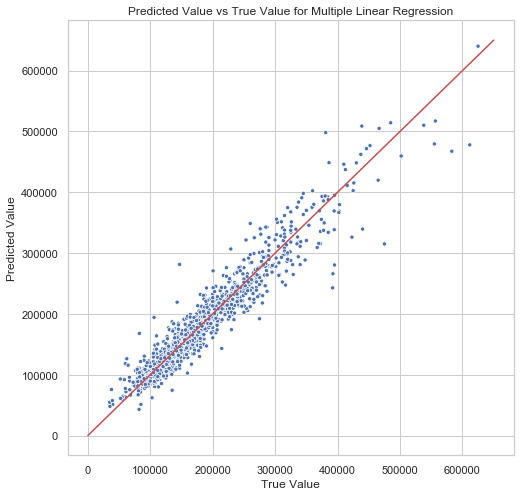

In [12]:
plt.figure(figsize=(8,8))
sns.scatterplot(x = saleprice, y = pred, size = 8, legend = False)
plt.plot([0,650000],[0,650000], color = "r")
plt.title("Predicted Value vs True Value for Multiple Linear Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Ridge Regression

In [13]:
ridge = Ridge(normalize = True)

In [14]:
alpha_100 = np.logspace(-5,5, 100)
coef = []
for i in alpha_100:
    ridge.set_params(alpha = i)
    ridge.fit(X, Y)
    coef.append(ridge.coef_)

Text(0, 0.5, 'coefficients')

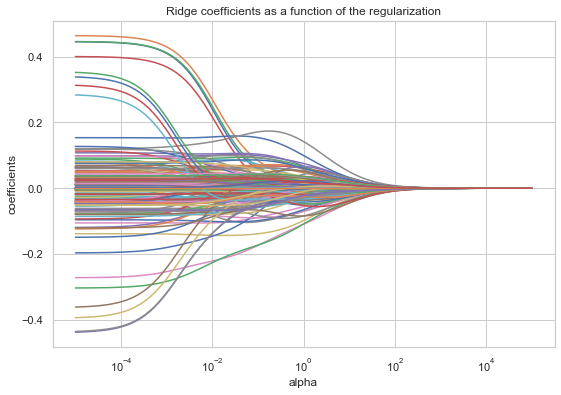

In [15]:
df_coef = pd.DataFrame(coef, index=alpha_100)
title = 'Ridge coefficients as a function of the regularization'
axes = df_coef.plot(logx = True, title=title, legend = False)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')

In [16]:
ridgecv = RidgeCV(alphas = alpha_100, normalize = True, cv = 5)

In [17]:
pred = model_eval(ridgecv)

RidgeCV model evaluation
--------------------------------------------------
Mean R-square with 5 Fold Cross Validation: 0.93058
RMSLE: 0.10433


In [18]:
ridgecv_coef = pd.DataFrame(ridgecv.coef_, index = X.columns).rename(columns = {0:"Coef."})
ridgecv_coef
# ridgecv_coef.reindex(ridgecv_coef["Coef."].abs().sort_values(ascending = False).index)

,Coef.
MSZoning_FV,0.207465
MSZoning_RH,0.237786
MSZoning_RL,0.216602
MSZoning_RM,0.185556
LotShape_Reg,0.003622
LandContour_NotLvl,-0.001394
LotConfig_CulDSac,0.037383
LotConfig_FR,-0.039977
LotConfig_Inside,-0.005858
Neighborhood_Blueste,-0.036778


Text(0, 0.5, 'Predicted Value')

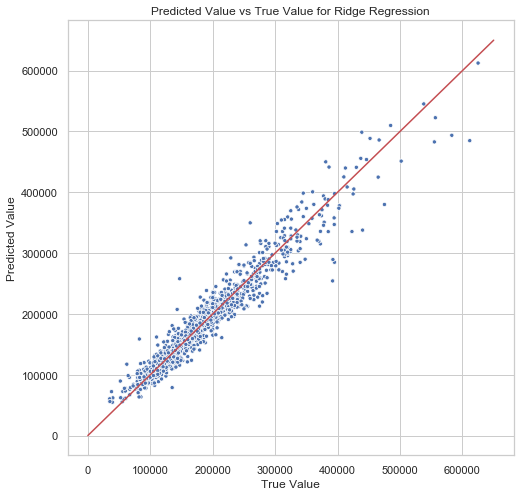

In [19]:
plt.figure(figsize=(8,8))
sns.scatterplot(x = saleprice, y = pred, size = 8, legend = False)
plt.plot([0,650000],[0,650000], color = "r")
plt.title("Predicted Value vs True Value for Ridge Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Lasso Regression

In [20]:
lasso = Lasso(normalize = True, max_iter = 10000)

In [21]:
alpha_100 = np.logspace(-7,-1, 100)
coef = []
for i in alpha_100:
    lasso.set_params(alpha = i)
    lasso.fit(X, Y)
    coef.append(lasso.coef_)

Text(0, 0.5, 'coefficients')

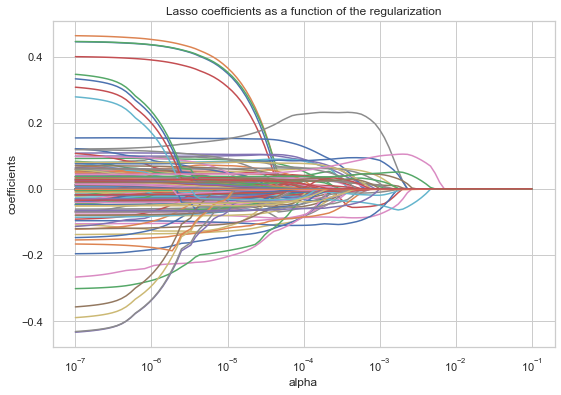

In [22]:
df_coef = pd.DataFrame(coef, index=alpha_100)
title = 'Lasso coefficients as a function of the regularization'
axes = df_coef.plot(logx = True, title=title, legend = False)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')

In [23]:
lassocv = LassoCV(alphas = None, normalize = True, cv = 5, max_iter = 10000)

In [24]:
pred = model_eval(lassocv)

LassoCV model evaluation
--------------------------------------------------
Mean R-square with 5 Fold Cross Validation: 0.92957
RMSLE: 0.10508


In [25]:
lassocv_coef = pd.DataFrame(lassocv.coef_, index = X.columns).rename(columns = {0:"Coef."})
lassocv_imp = lassocv_coef[lassocv_coef["Coef."] > 0]
lassocv_imp
ridgecv_coef.reindex(ridgecv_coef["Coef."].abs().sort_values(ascending = False).index)

,Coef.
MSZoning_RH,0.237786
ExterCond_Po,-0.217774
Exterior1st_BrkComm,-0.217235
MSZoning_RL,0.216602
MSZoning_FV,0.207465
MSZoning_RM,0.185556
Neighborhood_StoneBr,0.156952
OverallQual_EX,0.144802
Neighborhood_MeadowV,-0.143497
HouseStyle_2.5Fin,-0.139832


Text(0, 0.5, 'Predicted Value')

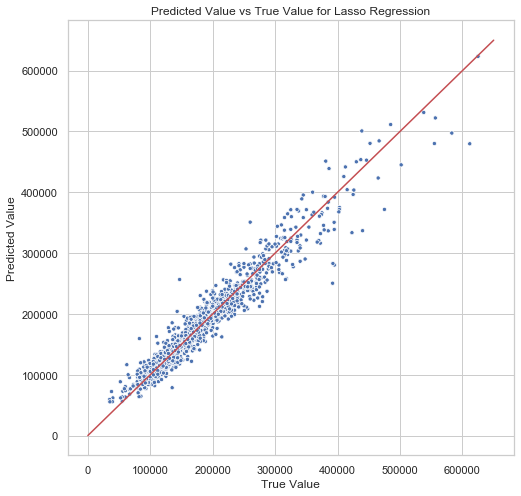

In [29]:
plt.figure(figsize=(8,8))
sns.scatterplot(x = saleprice, y = pred, size = 8, legend = False)
plt.plot([0,650000],[0,650000], color = "r")
plt.title("Predicted Value vs True Value for Lasso Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Format for Kaggle Submission

In [26]:
# sample = pd.read_csv("../sample_submission.csv", index_col = "Id")
# sample["SalePrice"] = np.exp(pred)
# sample.to_csv("RF.csv")

In [27]:
# sample